> ## Get that Avo Toast.  
***It's not like you can afford a home in the Bay anyway.***

This is my third attempt at avocado price prediction. My first attempt was using fb prophet, second attempt was using regression, and both methods did not work. Fbprophet only worked for univariate dataset, but I wanted to use the region variable as well. And the regression models could not predict future dates.  
It seems like for multivariate time series data, I would need a more complex model like neural networks. Hence I am trying LSTM this time. Let's see if third time will be a charm.  

*This is also my first Kaggle/data science project and any criticism/feedback is welcomed :) *


### Goal
Predict the region-specific avocado price based on total volume and historical average price.


In [1]:
import numpy as np 
import pandas as pd 
import os
import math, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../input/avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
df = df.drop(['Unnamed: 0'], 1)

In [4]:
scaler = StandardScaler()
df.loc[:,'Total Volume':'XLarge Bags']= scaler.fit_transform(df.loc[:,'Total Volume':'XLarge Bags'])

Normalizing the volume columns.

In [5]:
df['type']=df['type'].replace('conventional', 0)
df['type']=df['type'].replace('organic', 1)

Label encoding and one-hot encoding the categorical variables.

In [6]:
region_ohe = OneHotEncoder(categories = "auto", handle_unknown = "ignore")
X_encoded = region_ohe.fit_transform(df['region'].values.reshape(-1,1)).toarray()
X_encoded = pd.DataFrame(X_encoded, columns = [str(int(i)) for i in range(X_encoded.shape[1])])
X = df.drop(['year', 'region'], 1)
dff = pd.concat([X, X_encoded], axis = 1)
#moving AveragePrice to the last column
dff['Price']=dff.AveragePrice
dff.drop(['AveragePrice'], 1, inplace=True)
dff.head()

,Date,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,...,45,46,47,48,49,50,51,52,53,Price
0,2015-12-27,-0.227716,-0.230816,-0.199902,-0.212091,-0.234170,-0.232647,-0.222352,-0.17558,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.33
1,2015-12-20,-0.230427,-0.231103,-0.208054,-0.211997,-0.233350,-0.231568,-0.222335,-0.17558,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35
2,2015-12-13,-0.212085,-0.231007,-0.154478,-0.211325,-0.234730,-0.233399,-0.222311,-0.17558,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.93
3,2015-12-06,-0.223444,-0.230741,-0.185350,-0.211864,-0.237096,-0.236568,-0.222186,-0.17558,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.08
4,2015-11-29,-0.231538,-0.230891,-0.208719,-0.211834,-0.236718,-0.236154,-0.221924,-0.17558,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.28


In [7]:
dff=dff.set_index('Date')
dff.tail()

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,0,...,45,46,47,48,49,50,51,52,53,Price
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-04,-0.241373,-0.230017,-0.243857,-0.212540,-0.229301,-0.226665,-0.220964,-0.17558,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.63
2018-01-28,-0.242296,-0.230693,-0.242277,-0.212540,-0.233594,-0.232196,-0.221403,-0.17558,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.71
2018-01-21,-0.242331,-0.230693,-0.243090,-0.205766,-0.233463,-0.231644,-0.222561,-0.17558,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.87
2018-01-14,-0.241625,-0.230428,-0.242651,-0.205774,-0.231866,-0.229543,-0.222529,-0.17558,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.93
2018-01-07,-0.241253,-0.229347,-0.243170,-0.210450,-0.230807,-0.228111,-0.222628,-0.17558,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.62


Using the date column as index.

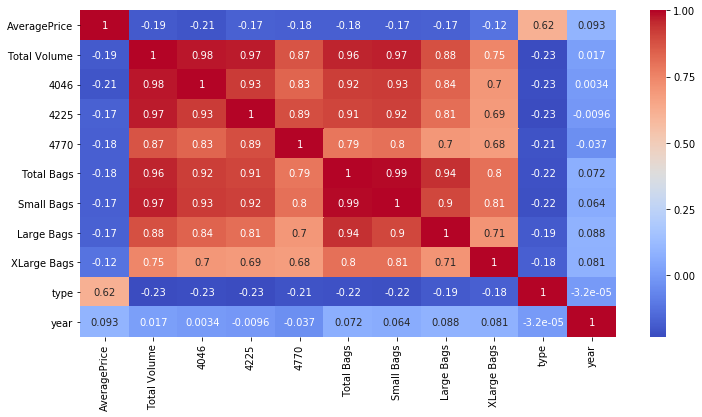

In [8]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

It seems like the quantities are highly correlated between each other, but not very much with the average price... This is not good since the variables should be independent. I should just keep one and drop the others, I will keep Total Volume.

In [9]:
df2 = dff.drop(dff.loc[:,'4046': 'XLarge Bags'], 1)

In [10]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [11]:
def load_data(df, seq_len):
    amount_of_features = len(df.columns) # 5
    data = df.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    print(result.shape)
    row = round(0.9 * result.shape[0]) # 90% split
    print("row: ", row)
    train = result[:int(row), :] # 90% date, all features 
    #print(train.shape)
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [12]:
window = 10
X_train, y_train, X_test, y_test = load_data(df2, window)

(18238, 11, 57)
row:  16414


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [14]:
model = build_model([57,window,1])

Compilation Time :  0.03185582160949707


In [15]:
model.fit(X_train,y_train,batch_size=100,epochs=50,validation_split=0.1,verbose=1)

Train on 14772 samples, validate on 1642 samples
Epoch 1/50
14772/14772 [==============================] - 18s 1ms/step - loss: 0.2102 - acc: 0.0104 - val_loss: 0.1396 - val_acc: 0.0079
Epoch 2/50
14772/14772 [==============================] - 16s 1ms/step - loss: 0.0562 - acc: 0.0126 - val_loss: 0.1009 - val_acc: 0.0085
Epoch 3/50
14772/14772 [==============================] - 16s 1ms/step - loss: 0.0466 - acc: 0.0129 - val_loss: 0.0808 - val_acc: 0.0085
Epoch 4/50
14772/14772 [==============================] - 16s 1ms/step - loss: 0.0389 - acc: 0.0131 - val_loss: 0.0829 - val_acc: 0.0085
Epoch 5/50
14772/14772 [==============================] - 16s 1ms/step - loss: 0.0352 - acc: 0.0132 - val_loss: 0.0586 - val_acc: 0.0085
Epoch 6/50
14772/14772 [==============================] - 16s 1ms/step - loss: 0.0325 - acc: 0.0133 - val_loss: 0.0540 - val_acc: 0.0085
Epoch 7/50
14772/14772 [==============================] - 16s 1ms/step - loss: 0.0317 - acc: 0.0132 - val_loss: 0.0510 - val_acc:

In [16]:
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
print(p[-1]) 

(1824, 1)
[1.8049082]


In [17]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.02315 MSE (0.15 RMSE)
Test Score: 0.04649 MSE (0.22 RMSE)


(0.023152701752093514, 0.046487493918424376)

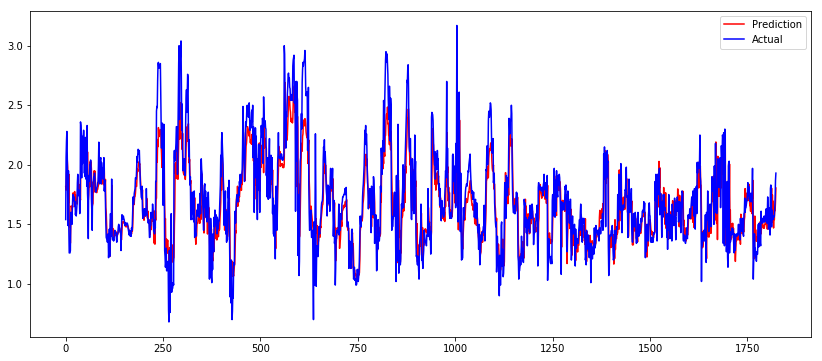

In [18]:
import matplotlib.pyplot as plt2
plt2.figure(figsize=(14,6))
plt2.plot(p,color='red', label='Prediction')
plt2.plot(y_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

From the model score and the plot, it seems like the model is doing a pretty good job. But I'm not confident at all since I cannot justify all the parameters that I'm using (sequence length, batch size, units, number of layers, etc.)... I'm sure there is a lot of room for optimization, but I think (hope) that the overall structure of the model is right at least? 

### Now let's try predicting the price of a new/future date.

I will go through a series of clunky steps to get the user's input into the right shape for the model.
I'm aware that I might be taking a lot of detours and unecessary steps here... would love to know if there's a better alternative.

In [19]:
regiondict = {}
for key, value in enumerate(df.region.unique()):
    regiondict[key] = value

In [20]:
def OHE_region (region): #region is a string   
    #get the region number as mapped in the dict
    regionnum = list(regiondict.keys())[list(regiondict.values()).index(region)]   
    #create regionnum columns of 0, concat one column of 1 at index regionnum, then concat 53-regionnum columns of 0.
    before_df = pd.DataFrame(0.0, index=range(1), columns = list(range(regionnum)))
    after_df = pd.DataFrame(0.0, index=range(1), columns = list(range(regionnum+1, 54)))
    new_df = pd.DataFrame(1.0, index=range(1), columns = [str(regionnum)])
    OHE_df = pd.concat([before_df, new_df, after_df], axis=1) 
    return OHE_df

In [21]:
OHE_region('Tampa')

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
X_dict = {'Date': '2019-08-12', 'Total Volume': dff['Total Volume'].mean(), 'type': 0}
X_df = pd.DataFrame([X_dict])
new_X = pd.DataFrame(X_df, columns=X_dict.keys()) #hacky/dumb way of making sure that the columns in the df maintain the same order as in the dict.
encoded_region = OHE_region('Houston')
new_X = pd.concat([new_X, encoded_region], axis=1)
new_X=new_X.set_index('Date')
print(new_X)

            Total Volume  type    0    1    2    3    4    5    6    7 ...   \
Date                                                                   ...    
2019-08-12  8.391160e-17     0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    

             44   45   46   47   48   49   50   51   52   53  
Date                                                          
2019-08-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 56 columns]


In [23]:
#new_X=new_X.reshape(1,1,56)

In [24]:
#model.predict(new_X)

### stuck - TBC. 